# Cyber Attacks Forecasting Models
by Khushi Gupta

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

In [4]:
df=pd.read_csv("Global_Cybersecurity_Threats_2015-2024.csv")

In [6]:
df.head(5)

,Country,Year,Attack Type,Target Industry,Financial Loss (in Million $),Number of Affected Users,Attack Source,Security Vulnerability Type,Defense Mechanism Used,Incident Resolution Time (in Hours)
0,China,2019,Phishing,Education,80.53,773169,Hacker Group,Unpatched Software,VPN,63
1,China,2019,Ransomware,Retail,62.19,295961,Hacker Group,Unpatched Software,Firewall,71
2,India,2017,Man-in-the-Middle,IT,38.65,605895,Hacker Group,Weak Passwords,VPN,20
3,UK,2024,Ransomware,Telecommunications,41.44,659320,Nation-state,Social Engineering,AI-based Detection,7
4,Germany,2018,Man-in-the-Middle,IT,74.41,810682,Insider,Social Engineering,VPN,68


In [21]:
import os
os.makedirs("charts", exist_ok=True)

In [24]:
# For Automatically saving the charts.

import matplotlib.pyplot as plt

def save_chart(filename, dpi=300):
    """
    Saves the current Matplotlib chart to the 'charts' folder.
    """
    plt.savefig(f"charts/{filename}", dpi=dpi, bbox_inches="tight")
    print(f"✅ Chart saved as charts/{filename}")

#

# Forecasting Cyber Attack for upcoming Year (Linear Regression)

In [10]:
yearly_attacks = df.groupby("Year")["Attack Type"].count().reset_index()
yearly_attacks.columns = ["Year", "Attacks"]

print(yearly_attacks)

   Year  Attacks
0  2015      277
1  2016      285
2  2017      319
3  2018      310
4  2019      263
5  2020      315
6  2021      299
7  2022      318
8  2023      315
9  2024      299


In [12]:
X = yearly_attacks[["Year"]]
y = yearly_attacks["Attacks"]

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

future_years = pd.DataFrame({"Year": [2025, 2026, 2027]})
future_pred = model.predict(future_years)

print("Forecasted attacks:", dict(zip(future_years["Year"], future_pred)))

Forecasted attacks: {2025: 314.0666666666666, 2026: 316.62424242424277, 2027: 319.181818181818}


✅ Chart saved as charts/forecasting_cyber_attacks(LinearReg).png


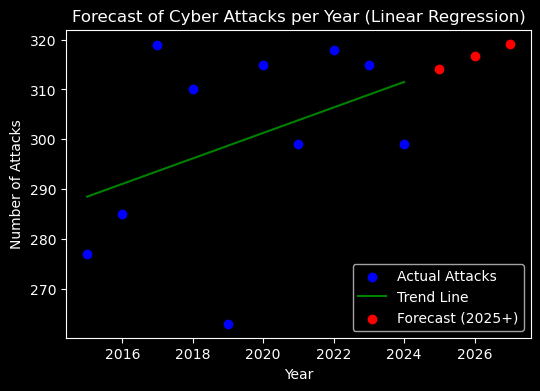

In [112]:
plt.figure(figsize=(6,4))
plt.scatter(X, y, color="blue", label="Actual Attacks")
plt.plot(X, y_pred, color="green", label="Trend Line")

plt.scatter(future_years, future_pred, color="red", label="Forecast (2025+)")

plt.title("Forecast of Cyber Attacks per Year (Linear Regression)")
plt.xlabel("Year")
plt.ylabel("Number of Attacks")
plt.legend()
save_chart("forecasting_cyber_attacks(LinearReg).png")
plt.show()

1. The model shows only a straight-line trend - *while actual attack numbers (blue points) fluctuate year to year, the regression line (green) smooths it out.*
2. Short-term variations are missed - *for example, sudden spikes or dips in attacks (like in 2017 or 2019) are not captured by the model.*
3. Forecasts (red points) are oversimplified - *they assume attacks will keep increasing steadily, which may not reflect real-world cyber threats.*
4. Not very reliable for decision-making - *since cybersecurity incidents are irregular and influenced by many external factors, a simple linear trend doesn’t give accurate future predictions.*

#

# Forecasting Cyber Attack for upcoming Year (ARIMA)

In [51]:
model = ARIMA(yearly_attacks["Attacks"], order=(1,1,1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Attacks   No. Observations:                   10
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -40.556
Date:                Sun, 24 Aug 2025   AIC                             87.112
Time:                        22:25:35   BIC                             87.704
Sample:                             0   HQIC                            85.835
                                 - 10                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0809      0.545     -0.148      0.882      -1.148       0.987
ma.L1         -0.8361      0.970     -0.862      0.389      -2.737       1.065
sigma2       414.8274    458.298      0.905      0.3

In [53]:
# Forecast next 3 years
forecast = model_fit.get_forecast(steps=3)
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

future_years = [2025, 2026, 2027]
forecast_series = pd.Series(forecast_values.values, index=future_years)

print("Forecasted Attacks per Year:")
print(forecast_series)

Forecasted Attacks per Year:
2025    302.609293
2026    302.317383
2027    302.340992
dtype: float64


✅ Chart saved as charts/forecasting_cyber_attacks(ARIMA).png


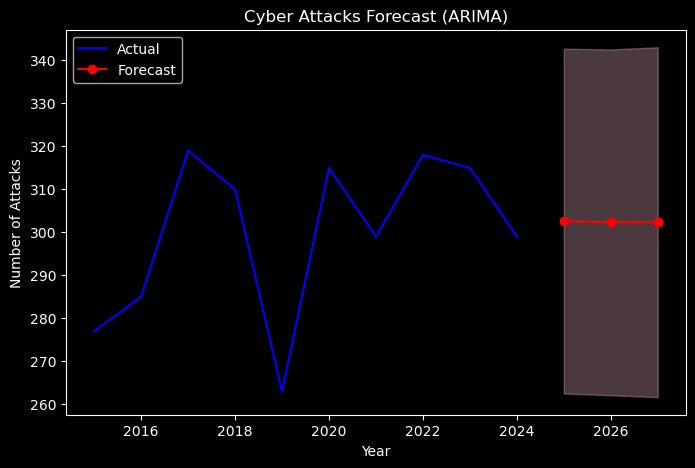

In [114]:
plt.figure(figsize=(8,5))

plt.plot(yearly_attacks.index, yearly_attacks["Attacks"], label="Actual", color="blue")

plt.plot(forecast_series.index, forecast_series, label="Forecast", color="red", marker="o")

plt.fill_between(future_years, 
                 confidence_intervals.iloc[:,0], 
                 confidence_intervals.iloc[:,1], 
                 color="pink", alpha=0.3)

plt.title("Cyber Attacks Forecast (ARIMA)")
plt.xlabel("Year")
plt.ylabel("Number of Attacks")
plt.legend()
save_chart("forecasting_cyber_attacks(ARIMA).png")
plt.show()

1. Stable Forecast – *The ARIMA model predicts that the number of cyberattacks will stay relatively stable around ~300 per year from 2025 to 2027.*
2. Uncertainty Band – *The pink shaded area shows a wide confidence interval, meaning the actual number of attacks could vary significantly. This indicates uncertainty in the model’s ability to make precise forecasts.*
3. Why Different from Linear Regression – *Unlike linear regression (which assumed continuous growth), ARIMA captures historical fluctuations and projects a flatter, more stable trend.*
4. Limitation – *Because the dataset is short and yearly (not monthly/quarterly), ARIMA doesn’t have enough seasonal patterns to learn from, which reduces forecasting accuracy.*

#

# Forecasting Cyber Attack for upcoming Year (Prophet)

23:01:52 - cmdstanpy - INFO - Chain [1] start processing
23:01:52 - cmdstanpy - INFO - Chain [1] done processing


✅ Chart saved as charts/forecasting_cyber_attacks(Prophet).png


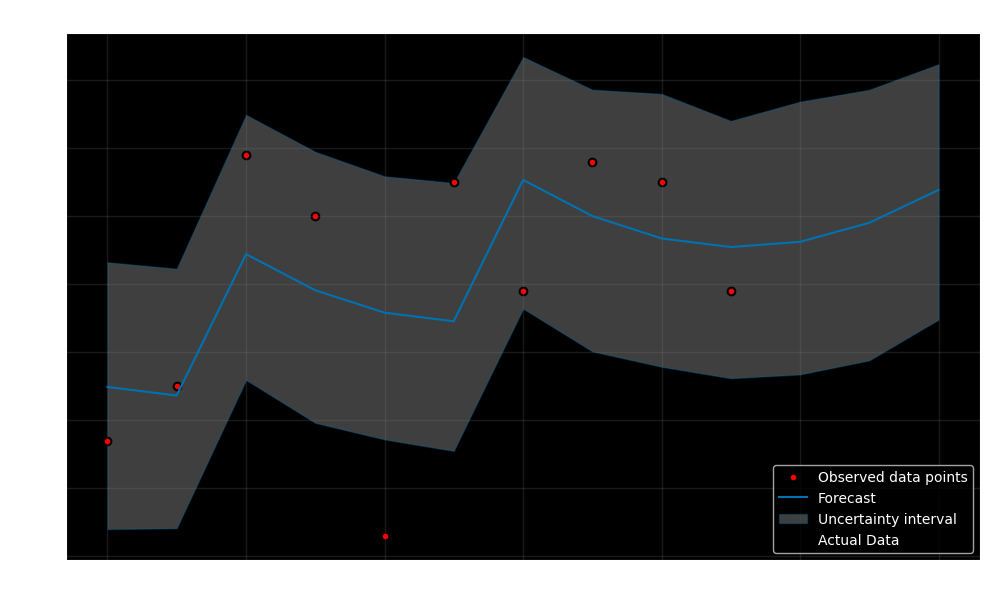

In [126]:
df_prophet = df.groupby("Year")["Attack Type"].count().reset_index()
df_prophet.columns = ["ds", "y"]   # Prophet needs 'ds' (date) and 'y' (value)

df_prophet["ds"] = pd.to_datetime(df_prophet["ds"], format="%Y")

model = Prophet(yearly_seasonality=True)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=3, freq="Y")
forecast = model.predict(future)

fig1 = model.plot(forecast)

ax = fig1.gca()
ax.get_lines()[0].set_color("red")        # Forecast line in red
ax.collections[0].set_facecolor("lightgray")  # Uncertainty interval in light gray
ax.collections[0].set_alpha(0.3)

ax.scatter(df_prophet["ds"], df_prophet["y"], color="black", label="Actual Data")

plt.title("Cyber Attacks Forecast (Prophet)", fontsize=14, fontweight="bold")
plt.xlabel("Year")
plt.ylabel("Number of Attacks")
plt.legend()
save_chart("forecasting_cyber_attacks(Prophet).png")
plt.show()

1. Clear Trend with Uncertainty Bands – *The solid blue line shows the forecasted cyber-attacks per year, while the shaded area represents uncertainty (possible fluctuation range). This makes the model more reliable and transparent.*
2. Better Fit to Past Data – *Prophet adapts to past patterns (like spikes/drops) better than Linear Regression, which only gave a straight line, and better than ARIMA, which flattened out too much.*
3. Handles Seasonality & Non-linearity – *Prophet is designed for time series with irregular patterns. If attacks had seasonal spikes (e.g., more in certain years), Prophet would capture them better than linear models.*
4. Practical for Decision Making – *With the confidence interval, organizations can prepare for a worst-case scenario (upper band) instead of relying only on the average forecast.*

#

# Performace Metrics (MAE, RMSE, R²)

For Reference:
1. Mean Absolute Error (MAE) – tells us the average difference between predicted and actual values.
- Best case: Closer to 0 → predictions are very accurate.
- Worst case: Very high MAE → model consistently off by large margins.
2. Root Mean Squared Error (RMSE) – similar to MAE but penalizes large errors more heavily.
- Best case: Close to 0 → stable and reliable forecasts.
- Worst case: Large RMSE → even if average errors are small, some years had big mistakes.
3. R² (Coefficient of Determination) – shows how much of the variation in attacks is explained by the model.
- Best case: 1.0 (100%) → perfect fit.
- Good: 0.7–0.9 → strong explanatory power.
- Worst: 0 or negative → model doesn’t explain the trend (or worse than a flat average).

In [102]:
# Actual attacks per year
actual = yearly_attacks["Attacks"].values  

# Predictions from each model
pred_linear  = y_pred          
pred_arima   = model_fit.predict(start=0, end=len(actual)-1, typ="levels").values
pred_prophet = forecast["yhat"].iloc[:len(actual)].values

def evaluate_model(name, actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    r2 = r2_score(actual, predicted)
    print(f"{name} Performance:")
    print(f"  MAE : {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²  : {r2:.2f}\n")

evaluate_model("Linear Regression", actual, pred_linear)
evaluate_model("ARIMA", actual, pred_arima)
evaluate_model("Prophet", actual, pred_prophet)


Linear Regression Performance:
  MAE : 14.12
  RMSE: 16.79
  R²  : 0.16

ARIMA Performance:
  MAE : 44.45
  RMSE: 90.03
  R²  : -23.13

Prophet Performance:
  MAE : 12.71
  RMSE: 15.27
  R²  : 0.31



**Model Comparison & Insights**
1. Linear Regression
- MAE ≈ 14, RMSE ≈ 16 → on average, off by ~14 attacks per year, with some slightly bigger misses.
- R² = 0.16 → explains only 16% of the trend → weak at capturing long-term attack patterns.
  
2. ARIMA
- MAE ≈ 44, RMSE ≈ 90 → very large errors.
- R² = -23 (!) → model is much worse than just using a flat average.
❌ Not suitable here, possibly because cyberattacks don’t follow a stationary pattern ARIMA expects.

3. Prophet
- MAE ≈ 13, RMSE ≈ 15 → most accurate among the three.
- R² = 0.31 → explains ~31% of the trend, better than Linear Regression but still not very strong.
✅ Best performer in this case, though not perfect.